# Búsqueda de parámetros de predicción

Ensayo de variables explicativas (atributos de parcela) para la estimación del usdm2

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## 1. Target y variables explicativas 

Información extraída de la [API de catastro](https://datosabiertos-apis.buenosaires.gob.ar/BA_Root/Documentacion?schema_name=catastro) de GCBA.

In [2]:
xvars_df = pd.read_csv('../data/expvars_12092022.csv', index_col='smp')

In [3]:
xvars_df.sample(2)

,superficie_total,superficie_cubierta,frente,fondo,propiedad_horizontal,pisos_bajo_rasante,pisos_sobre_rasante,unidades_funcionales,locales,vuc,cantidad_puertas,lon_ctroid,lat_ctroid
smp,,,,,,,,,,,,,
052-019A-003a,281.0,396.0,8.64,32.52,1.0,0.0,2.0,5.0,0.0,0.0,3.0,101746.441312,96392.857372
082-073Q-005,450.0,3844.0,25.02,17.99,1.0,0.0,17.0,59.0,0.0,0.0,3.0,99722.415129,93997.976446


In [4]:
xvars_df.columns

Index(['superficie_total', 'superficie_cubierta', 'frente', 'fondo',
       'propiedad_horizontal', 'pisos_bajo_rasante', 'pisos_sobre_rasante',
       'unidades_funcionales', 'locales', 'vuc', 'cantidad_puertas',
       'lon_ctroid', 'lat_ctroid'],
      dtype='object')

In [5]:
# TODO: revisar en notebook de consistencias por que hay parcelas repetidas
xvars_df = xvars_df[~xvars_df.duplicated()].copy()

In [6]:
expvars = ['superficie_total', 'superficie_cubierta', 'frente', 'fondo',
           'propiedad_horizontal', 'pisos_bajo_rasante', 'pisos_sobre_rasante',
           'unidades_funcionales', 'locales', 'vuc', 'cantidad_puertas',
           'lat_ctroid', 'lon_ctroid']

In [7]:
from REM.datasources import *

In [8]:
# construcción del area de recorte 
thiner_path = '../data/BarOli_V1/layers/P_BP_AREA_5347.shp'
mascara = thiner_bound(path=thiner_path)
parcelas = caba_parcelas(source_idx=1)
parcelas_sur = build_study_area(parcelas, mascara)

Leyendo parcelas desde directorio local ...


/home/federico/federico/CEEU/bolimpico/REM/REM/datasources.py:92: UserWarning: Los sistemas de coordenadas difieren. Adaptando mascara a CRS de parcelas
  warnings.warn("Los sistemas de coordenadas difieren. Adaptando mascara a CRS de parcelas")


In [9]:
# area
gkbs = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'
parcelas_sur['area'] = parcelas_sur.to_crs(gkbs).geometry.area

In [10]:
# valuacion usdm2
parcelas_sur = parcelas_sur[['smp','area','geometry']].set_index('smp').copy()
valuacion_sur = gpd.read_file("../data/parcelas_usdm2_cu.geojson")
valuacion_codigo_urbano = dict(zip(valuacion_sur['smp'], valuacion_sur['usdm2']))
parcelas_sur['usdm2'] = parcelas_sur.index.map(valuacion_codigo_urbano)

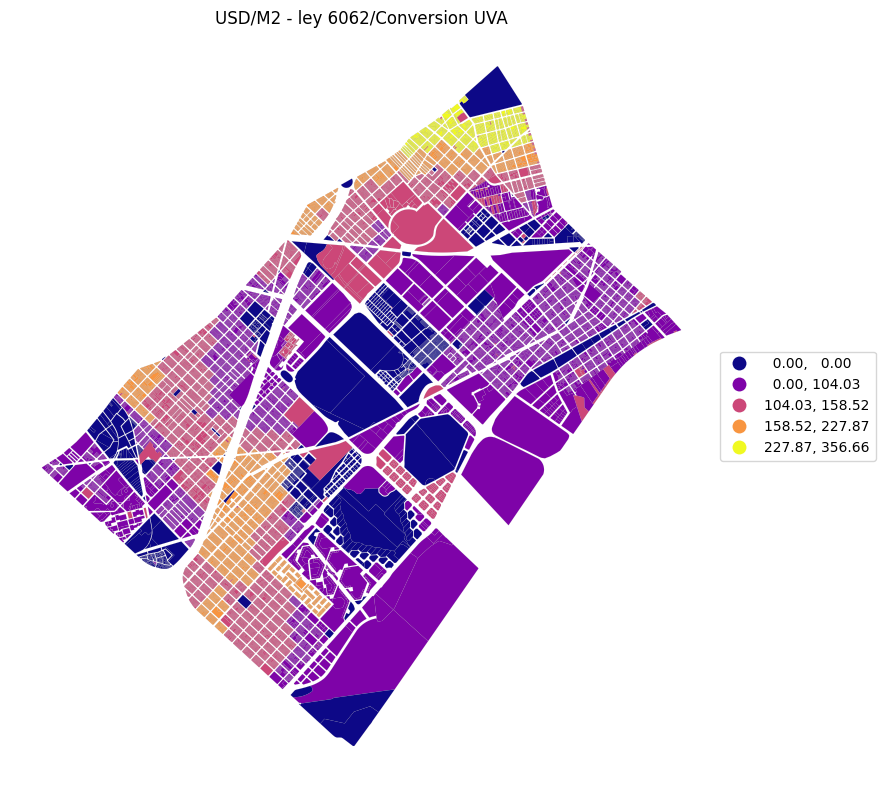

In [11]:
f,ax = plt.subplots(figsize=(12,8))
parcelas_sur.plot(ax=ax, column='usdm2', k=5, cmap='plasma', 
                  scheme='NaturalBreaks', edgecolor='gray', linewidth=0.05,
                  legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
ax.set_axis_off()
ax.set_title('USD/M2 - ley 6062/Conversion UVA',fontsize=12)
plt.tight_layout();

******************************************************************************************************************

#### TODO: por el clip hay parcelas que se repiten. Evitar geoproceso y usar lista de idx

In [12]:
len(parcelas_sur)

28070

In [13]:
parcelas_sur_ = parcelas_sur.join(xvars_df)

In [14]:
len(parcelas_sur_)

28072

In [15]:
parcelas_sur_.index.value_counts().head(1)

068-123H-001c    4
Name: smp, dtype: int64

In [16]:
parcelas_sur.index.value_counts().head(1)

068-123H-001c    2
Name: smp, dtype: int64

In [17]:
parcelas_sur_

,area,geometry,usdm2,superficie_total,superficie_cubierta,frente,fondo,propiedad_horizontal,pisos_bajo_rasante,pisos_sobre_rasante,unidades_funcionales,locales,vuc,cantidad_puertas,lon_ctroid,lat_ctroid
smp,,,,,,,,,,,,,,,,
042-043A-000,234113.349884,"POLYGON ((-58.44129 -34.63222, -58.44059 -34.6...",0.000000,438.006669,482.371556,11.020355,38.069642,0.6,0.2,6.2,34.8,0.0,0.0,6.0,101798.208338,99497.753097
042-043B-001a,201.162479,"POLYGON ((-58.44628 -34.63442, -58.44635 -34.6...",356.659794,203.000000,1456.000000,8.660000,23.440000,1.0,0.0,8.0,8.0,0.0,0.0,1.0,101495.433241,99484.246934
042-043B-001b,387.522920,"POLYGON ((-58.44635 -34.63448, -58.44628 -34.6...",356.659794,389.000000,3195.000000,8.770000,44.360000,1.0,1.0,12.0,48.0,0.0,0.0,2.0,101495.096668,99473.783109
042-043B-002,298.445037,"POLYGON ((-58.44635 -34.63460, -58.44642 -34.6...",356.659794,302.000000,1122.000000,8.680000,34.790000,1.0,0.0,5.0,13.0,0.0,0.0,1.0,101485.549532,99468.988229
042-043B-003a,296.965929,"POLYGON ((-58.44642 -34.63465, -58.44649 -34.6...",356.659794,297.000000,308.000000,8.600000,34.540000,1.0,0.0,1.0,4.0,0.0,0.0,2.0,101479.101874,99463.294128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
084-063-002,1424.960619,"POLYGON ((-58.46519 -34.69094, -58.46544 -34.6...",59.443299,1421.000000,0.000000,30.710000,46.270000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,99745.210039,93209.421598
084-063-003,1637.365941,"POLYGON ((-58.46519 -34.69094, -58.46480 -34.6...",59.443299,1658.000000,4959.000000,47.630000,34.810000,1.0,0.0,10.0,75.0,0.0,0.0,5.0,99777.814423,93179.609178
084-063-004,1447.931876,"POLYGON ((-58.46480 -34.69122, -58.46447 -34.6...",59.443299,1437.000000,5316.000000,37.340000,38.480000,1.0,0.0,10.0,76.0,0.0,0.0,6.0,99810.447425,93149.900889


In [18]:
parcelas_sur.loc['068-123H-001c']

,area,geometry,usdm2
smp,,,
068-123H-001c,800.588216,"POLYGON ((-58.45277 -34.67731, -58.45292 -34.6...",148.608247
068-123H-001c,800.874873,"POLYGON ((-58.45262 -34.67717, -58.45277 -34.6...",148.608247


In [19]:
parcelas_sur_.loc['068-123H-001c'].iloc[[0,2]]

,area,geometry,usdm2,superficie_total,superficie_cubierta,frente,fondo,propiedad_horizontal,pisos_bajo_rasante,pisos_sobre_rasante,unidades_funcionales,locales,vuc,cantidad_puertas,lon_ctroid,lat_ctroid
smp,,,,,,,,,,,,,,,,
068-123H-001c,800.588216,"POLYGON ((-58.45277 -34.67731, -58.45292 -34.6...",148.608247,438.006669,482.371556,11.020355,38.069642,0.237752,0.003968,1.304384,2.057428,0.0,0.0,1.769626,100888.924718,94727.135993
068-123H-001c,800.874873,"POLYGON ((-58.45262 -34.67717, -58.45277 -34.6...",148.608247,438.006669,482.371556,11.020355,38.069642,0.237752,0.003968,1.304384,2.057428,0.0,0.0,1.769626,100888.924718,94727.135993


In [20]:
parcelas_sur__ = parcelas_sur_[~parcelas_sur_.index.isin(['068-123H-001c'])].copy()
parcelas_sur = pd.concat([parcelas_sur__,parcelas_sur_.loc['068-123H-001c'].iloc[[0,2]]])

******************************************************************************************************************

In [21]:
from REM.utils import neighbor_fields

In [22]:
target_var = 'usdm2'

In [23]:
# precios vecinos
ngb_gdf = parcelas_sur.reset_index()
precio_vcnos = neighbor_fields(poly_gdf=ngb_gdf, proj=gkbs, N_NEAREST=10, field_name=target_var)

In [24]:
N_NEAREST = 10
NEAREST_COLS = list(map("nearest_price_{}".format, range(1, N_NEAREST + 1)))

precio_vcnos_avg = precio_vcnos[['smp']+ NEAREST_COLS].copy()
precio_vcnos_avg['avg_price'] = precio_vcnos_avg[NEAREST_COLS].mean(axis=1)

usdm2_vecinos = dict(zip(precio_vcnos_avg['smp'], precio_vcnos_avg['avg_price'])) 

In [25]:
parcelas_sur['precios_vecinos'] = parcelas_sur.index.map(usdm2_vecinos)

## 4. Entrenamiento 

In [26]:
from REM.models import *

In [27]:
expvars

['superficie_total',
 'superficie_cubierta',
 'frente',
 'fondo',
 'propiedad_horizontal',
 'pisos_bajo_rasante',
 'pisos_sobre_rasante',
 'unidades_funcionales',
 'locales',
 'vuc',
 'cantidad_puertas',
 'lat_ctroid',
 'lon_ctroid']

In [28]:
expvar_names = expvars+['area','precios_vecinos']

In [29]:
model_data = parcelas_sur.copy()

In [30]:
X, y = model_data[expvar_names], model_data[target_var]
data_dmatrix = xgb.DMatrix(data=X,label=y, enable_categorical=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### 4.1. Línea de base 

In [31]:
# regresor con parametros por defecto
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.5, 
                          learning_rate = 0.3,
                          max_depth = 6, 
                          alpha = 0, 
                          n_estimators = 100,
                         )

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

In [32]:
print_scores(y_test, preds) 

RMSE: 9.589123
R_Squared Score : 0.988657


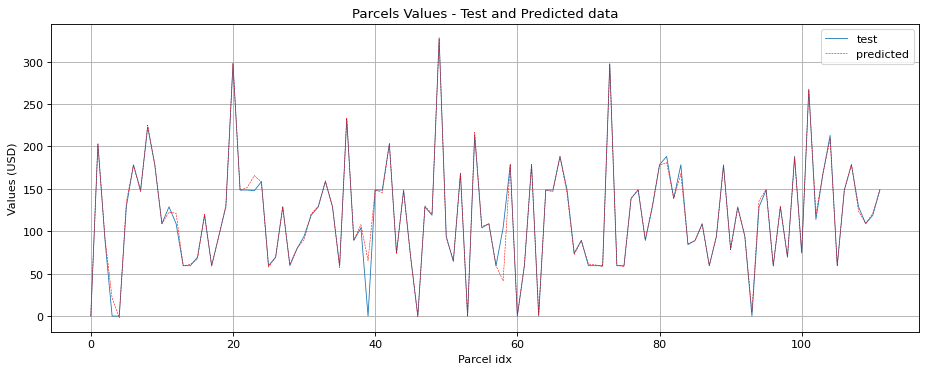

In [33]:
seleccion = int(len(y_test)/50)
x_ax = range(seleccion)
plot_predicted_vs_test(x_ax, y_test[:seleccion], preds[:seleccion], predicted_name='Values')

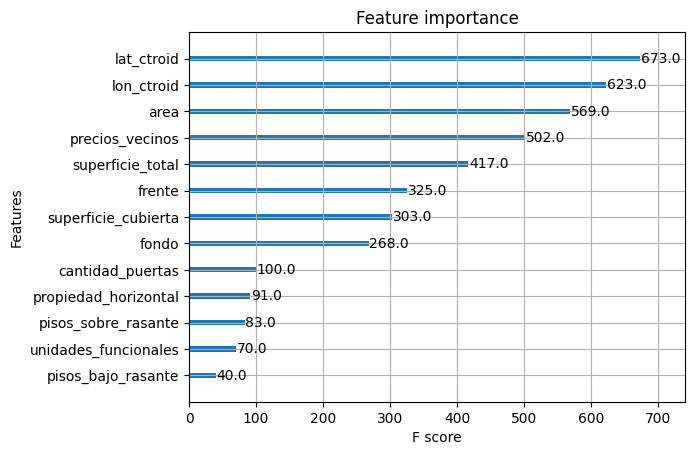

In [34]:
xgb.plot_importance(xg_reg);

### 4.2. Reducción del RMSE 

Definición de parámetros para implementación de python en el siguiente [link](https://xgboost.readthedocs.io/en/stable/parameter.html). 

In [35]:
# definimos nuevos parametros más conservadores 
baseline_params = [0.3, 0.1, 5, 10, 45]

In [36]:
# exploracion de parametros alternativos
alternative_params = {
                      'colsample_bytree': np.linspace(0.1, 1, num=10), 
                      'learning_rate': np.linspace(0.1, 1, num=10), 
                      'max_depth': list(range(1,15+1)), 
                      'alpha':list(range(1,15+1)),
                      'num_boost_round': list(range(10,100+1,5)) 
                      }

In [37]:
min_rmse_scores = {}
nf = 10

for k in alternative_params.keys():
    
    if 'colsample_bytree' in k:
        colsample_bytree_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = colsample_bytree_scores
    
    if 'learning_rate' in k:
        learning_rate_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = learning_rate_scores
        
    if 'max_depth' in k:
        max_depth_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = max_depth_scores
        
    if 'alpha' in k:
        alpha_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = alpha_scores
        
    if 'num_boost_round' in k:
        num_boost_round_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = num_boost_round_scores


Optimizing colsample_bytree
***************************
0.1
[0.1, 0.1, 5, 10, 45]
0.2
[0.2, 0.1, 5, 10, 45]
0.30000000000000004
[0.30000000000000004, 0.1, 5, 10, 45]
0.4
[0.4, 0.1, 5, 10, 45]
0.5
[0.5, 0.1, 5, 10, 45]
0.6
[0.6, 0.1, 5, 10, 45]
0.7000000000000001
[0.7000000000000001, 0.1, 5, 10, 45]
0.8
[0.8, 0.1, 5, 10, 45]
0.9
[0.9, 0.1, 5, 10, 45]
1.0
[1.0, 0.1, 5, 10, 45]

Optimizing learning_rate
************************
0.1
[0.3, 0.1, 5, 10, 45]
0.2
[0.3, 0.2, 5, 10, 45]
0.30000000000000004
[0.3, 0.30000000000000004, 5, 10, 45]
0.4
[0.3, 0.4, 5, 10, 45]
0.5
[0.3, 0.5, 5, 10, 45]
0.6
[0.3, 0.6, 5, 10, 45]
0.7000000000000001
[0.3, 0.7000000000000001, 5, 10, 45]
0.8
[0.3, 0.8, 5, 10, 45]
0.9
[0.3, 0.9, 5, 10, 45]
1.0
[0.3, 1.0, 5, 10, 45]

Optimizing max_depth
********************
1
[0.3, 0.1, 1, 10, 45]
2
[0.3, 0.1, 2, 10, 45]
3
[0.3, 0.1, 3, 10, 45]
4
[0.3, 0.1, 4, 10, 45]
5
[0.3, 0.1, 5, 10, 45]
6
[0.3, 0.1, 6, 10, 45]
7
[0.3, 0.1, 7, 10, 45]
8
[0.3, 0.1, 8, 10, 45]
9
[0.3, 0.1, 

Se evalúa la reducción del RMSE con el aumento de los valores de cada parametro (de más a menos conservador)

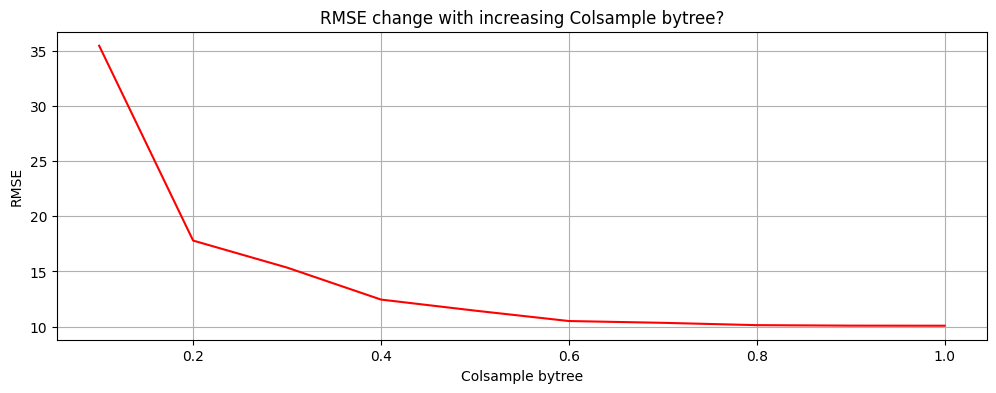

In [38]:
plot_min_rmse(alternatives=alternative_params['colsample_bytree'],
              results=min_rmse_scores['colsample_bytree_scores'],
              parameter='Colsample bytree', color='red')

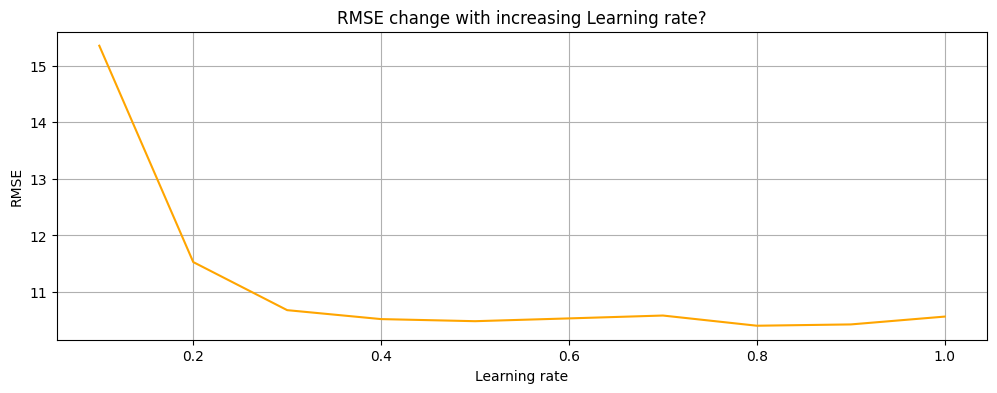

In [39]:
plot_min_rmse(alternatives=alternative_params['learning_rate'],
               results=min_rmse_scores['learning_rate_scores'],
               parameter='Learning rate', color='orange')

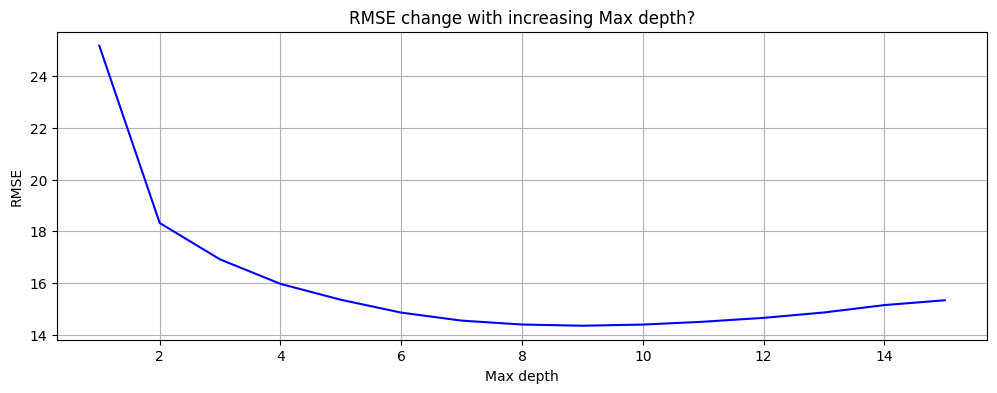

In [40]:
plot_min_rmse(alternatives=alternative_params['max_depth'],
               results=min_rmse_scores['max_depth_scores'],
               parameter='Max depth', color='blue')

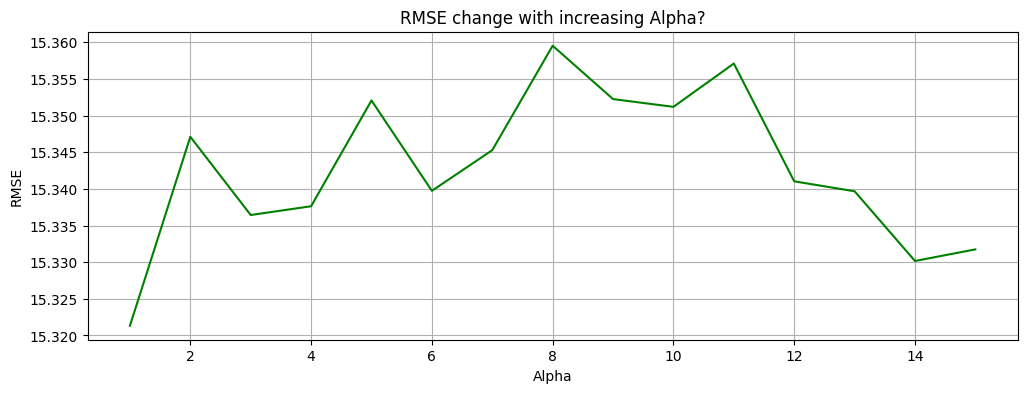

In [41]:
plot_min_rmse(alternatives=alternative_params['alpha'],
               results=min_rmse_scores['alpha_scores'],
               parameter='Alpha', color='green')

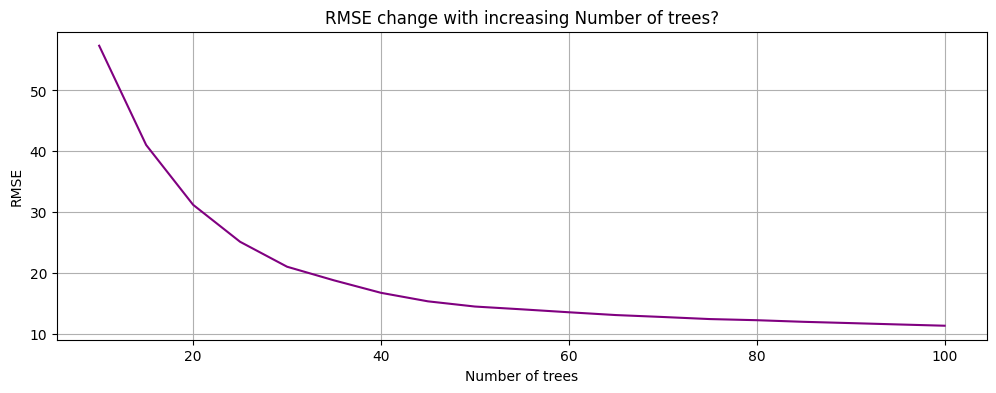

In [42]:
plot_min_rmse(alternatives=alternative_params['num_boost_round'],
               results=min_rmse_scores['num_boost_round_scores'],
               parameter='Number of trees', color='purple')

In [43]:
min_rmse_params = {}

params = ["colsample_bytree", "learning_rate", "max_depth", "alpha", "num_boost_round"]

for p in params:
    o = optimal_hyperparam(dict1=alternative_params[p], 
                           dict2=min_rmse_scores[p+'_scores'])
    min_rmse_params[p] = o

In [44]:
min_rmse_params # parametros que minimizan el RMSE

{'colsample_bytree': 1.0,
 'learning_rate': 0.8,
 'max_depth': 9,
 'alpha': 1,
 'num_boost_round': 100}

### 4.3. Restimación con min rmse de base

In [45]:
xg_reg_minrmse = xgb.XGBRegressor(objective ='reg:squarederror',
                                  colsample_bytree=0.5,# mantenemos el default
                                  learning_rate=min_rmse_params['learning_rate'],
                                  max_depth=min_rmse_params['max_depth'],
                                  alpha=min_rmse_params['alpha'],
                                  n_estimators=min_rmse_params['num_boost_round'])

xg_reg_minrmse.fit(X_train, y_train)

preds_minrmse = xg_reg_minrmse.predict(X_test)

In [46]:
print_scores(y_test, preds_minrmse) 

RMSE: 10.887861
R_Squared Score : 0.985352


## 6. Prediccion

In [47]:
# predicción en base al mejor regresor obtenido
pred_usdm2 = xg_reg.predict(X)

In [48]:
# agrega prediccion
parcelas_sur['pred_usdm2'] = pred_usdm2

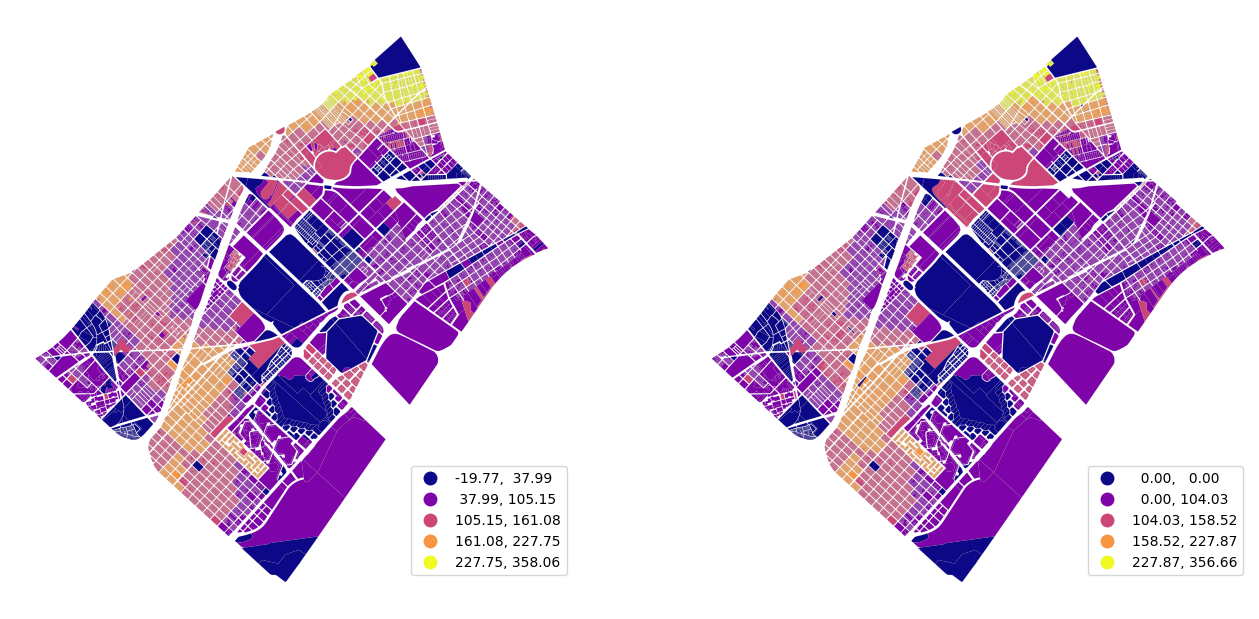

In [49]:
f, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16,9))

parcelas_sur.plot(column='pred_usdm2', ax=ax1, 
                  k=5, cmap='plasma', 
                  scheme='NaturalBreaks', edgecolor='gray', linewidth=0.05,
                  legend=True, legend_kwds={'loc': 'upper right', 'bbox_to_anchor':(1,0.25)})

parcelas_sur.plot(column='usdm2', ax=ax2, 
                  k=5, cmap='plasma', 
                  scheme='NaturalBreaks', edgecolor='gray', linewidth=0.05,
                  legend=True, legend_kwds={'loc': 'upper right', 'bbox_to_anchor':(1,0.25)})
for ax in [ax1,ax2]:               
    ax.set_axis_off();

### 6.1. Exporta modelo entrenado

Se guarda el mejor modelo obtenido

In [51]:
import joblib
joblib.dump(xg_reg, "../prices/parcels_pred_14092022.json") 

['../prices/parcels_pred_14092022.json']